
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/sed_fitting.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[sed_fitting.ipynb](../_static/notebooks/sed_fitting.ipynb) |
[sed_fitting.py](../_static/notebooks/sed_fitting.py)
</div>


# Flux point fitting in Gammapy

## Prerequisites

- Some knowledge about retrieving information from catalogs, see [the catalogs tutorial](catalog.ipynb)
 
## Context

Some high level studies do not rely on reduced datasets with their IRFs but directly on higher level products such as flux points. This is not ideal because flux points already contain some hypothesis for the underlying spectral shape and the uncertainties they carry are usually simplified (e.g. symmetric gaussian errors). Yet, this is an efficient way to combine heterogeneous data. 

**Objective: fit spectral models to combined Fermi-LAT and IACT flux points.**

## Proposed approach

Here we will load, the spectral points from Fermi-LAT and TeV catalogs and fit them with various spectral models to find the best representation of the wide band spectrum.
 
The central class we're going to use for this example analysis is:  

- `~gammapy.datasets.FluxPointsDataset`

In addition we will work with the following data classes:

- `~gammapy.estimators.FluxPoints`
- `~gammapy.catalog.SourceCatalogGammaCat`
- `~gammapy.catalog.SourceCatalog3FHL`
- `~gammapy.catalog.SourceCatalog3FGL`

And the following spectral model classes:

- `~gammapy.modeling.models.PowerLawSpectralModel`
- `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel`
- `~gammapy.modeling.models.LogParabolaSpectralModel`

## Setup

Let us start with the usual IPython notebook and Python imports:

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy import units as u
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
)
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.modeling import Fit

## Load spectral points

For this analysis we choose to work with the source 'HESS J1507-622' and the associated Fermi-LAT sources '3FGL J1506.6-6219' and '3FHL J1507.9-6228e'. We load the source catalogs, and then access source of interest by name:

In [3]:
catalog_3fgl = CATALOG_REGISTRY.get_cls("3fgl")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()
catalog_gammacat = CATALOG_REGISTRY.get_cls("gamma-cat")()

In [4]:
source_fermi_3fgl = catalog_3fgl["3FGL J1506.6-6219"]
source_fermi_3fhl = catalog_3fhl["3FHL J1507.9-6228e"]
source_gammacat = catalog_gammacat["HESS J1507-622"]

The corresponding flux points data can be accessed with `.flux_points` attribute:

In [5]:
flux_points_gammacat = source_gammacat.flux_points
flux_points_gammacat.table

e_ref,dnde,dnde_errn,dnde_errp
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float32,float32,float32,float32
0.8609,2.29119e-12,8.70543e-13,8.95502e-13
1.56151,6.98172e-13,2.20354e-13,2.30407e-13
2.76375,1.69062e-13,6.7587e-14,7.18838e-14
4.8916,7.72925e-14,2.40132e-14,2.60749e-14
9.98858,1.03253e-14,5.06315e-15,5.64195e-15
27.0403,7.44987e-16,5.72089e-16,7.25999e-16


In the Fermi-LAT catalogs, integral flux points are given. Currently the flux point fitter only works with differential flux points, so we apply the conversion here.

In [6]:
flux_points_3fgl = source_fermi_3fgl.flux_points.to_sed_type(
    sed_type="dnde", model=source_fermi_3fgl.spectral_model()
)
flux_points_3fhl = source_fermi_3fhl.flux_points.to_sed_type(
    sed_type="dnde", model=source_fermi_3fhl.spectral_model()
)

Finally we stack the flux points into a single `~gammapy.estimators.FluxPoints` object and drop the upper limit values, because currently we can't handle them in the fit:

In [7]:
# Stack flux point tables
flux_points = FluxPoints.stack(
    [flux_points_gammacat, flux_points_3fhl, flux_points_3fgl]
)

t = flux_points.table
t["dnde_err"] = 0.5 * (t["dnde_errn"] + t["dnde_errp"])

# Remove upper limit points, where `dnde_errn = nan`
is_ul = np.isfinite(t["dnde_err"])
flux_points = FluxPoints(t[is_ul])
flux_points

FluxPoints(sed_type='dnde', n_points=14)

## Power Law Fit

First we start with fitting a simple `~gammapy.modeling.models.PowerLawSpectralModel`.

In [8]:
pwl = PowerLawSpectralModel(
    index=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spectral_model=pwl)

After creating the model we run the fit by passing the `'flux_points'` and `'model'` objects:

In [9]:
dataset_pwl = FluxPointsDataset(model, flux_points)
fitter = Fit([dataset_pwl])
result_pwl = fitter.run()

And print the result:

In [10]:
print(result_pwl)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 40
	total stat : 28.29



In [11]:
print(pwl)

PowerLawSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 1.9854e+00                nan nan  False 2.832e-02
amplitude 1.2828e-12 cm-2 s-1 TeV-1 nan nan  False 1.599e-13
reference 1.0000e+00            TeV nan nan   True 0.000e+00


Finally we plot the data points and the best fit model:

/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:669: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:411: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/ga

(1e-13, 1e-11)

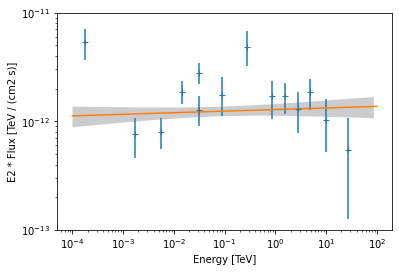

In [12]:
ax = flux_points.plot(energy_power=2)
pwl.plot(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)
pwl.plot_error(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)
ax.set_ylim(1e-13, 1e-11);

## Exponential Cut-Off Powerlaw Fit

Next we fit an `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel` law to the data.

In [13]:
ecpl = ExpCutoffPowerLawSpectralModel(
    index=1.8,
    amplitude="2e-12 cm-2 s-1 TeV-1",
    reference="1 TeV",
    lambda_="0.1 TeV-1",
)
model = SkyModel(spectral_model=ecpl)

We run the fitter again by passing the flux points and the model instance:

In [14]:
dataset_ecpl = FluxPointsDataset(model, flux_points)
fitter = Fit([dataset_ecpl])
result_ecpl = fitter.run()
print(ecpl)

ExpCutoffPowerLawSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 1.8943e+00                nan nan  False 4.700e-02
amplitude 1.9621e-12 cm-2 s-1 TeV-1 nan nan  False 3.899e-13
reference 1.0000e+00            TeV nan nan   True 0.000e+00
  lambda_ 7.7656e-02          TeV-1 nan nan  False 5.252e-02
    alpha 1.0000e+00                nan nan   True 0.000e+00


We plot the data and best fit model:

/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:669: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:411: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/ga

(1e-13, 1e-11)

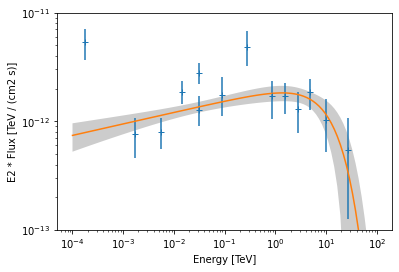

In [15]:
ax = flux_points.plot(energy_power=2)
ecpl.plot(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)
ecpl.plot_error(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)
ax.set_ylim(1e-13, 1e-11)

## Log-Parabola Fit

Finally we try to fit a `~gammapy.modeling.models.LogParabolaSpectralModel` model:

In [16]:
log_parabola = LogParabolaSpectralModel(
    alpha=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", beta=0.1
)
model = SkyModel(spectral_model=log_parabola)

In [17]:
dataset_log_parabola = FluxPointsDataset(model, flux_points)
fitter = Fit([dataset_log_parabola])
result_log_parabola = fitter.run()
print(log_parabola)

LogParabolaSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
amplitude 1.8768e-12 cm-2 s-1 TeV-1 nan nan  False 2.819e-13
reference 1.0000e+00            TeV nan nan   True 0.000e+00
    alpha 2.1437e+00                nan nan  False 7.273e-02
     beta 4.9355e-02                nan nan  False 1.823e-02


/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:669: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:411: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/ga

(1e-13, 1e-11)

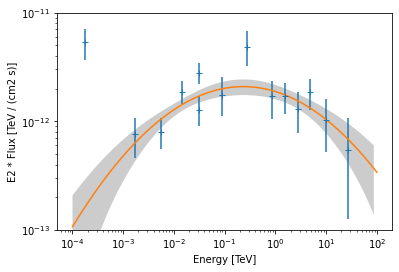

In [18]:
ax = flux_points.plot(energy_power=2)
log_parabola.plot(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)
log_parabola.plot_error(
    energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2
)
ax.set_ylim(1e-13, 1e-11);

## Exercises

- Fit a `~gammapy.modeling.models.PowerLaw2SpectralModel` and `~gammapy.modeling.models.ExpCutoffPowerLaw3FGLSpectralModel` to the same data.
- Fit a `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel` model to Vela X ('HESS J0835-455') only and check if the best fit values correspond to the values given in the Gammacat catalog

## What next?

This was an introduction to SED fitting in Gammapy.

* If you would like to learn how to perform a full Poisson maximum likelihood spectral fit, please check out the [spectrum analysis](spectrum_analysis.ipynb) tutorial.
* To learn how to combine heterogeneous datasets to perform a multi-instrument forward-folding fit see the [MWL analysis tutorial](analysis_mwl.ipynb)